In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

In [14]:
def hp(level, base_points):
    return (140 * 2 + 31 + base_points / 4) * level / 100 + 10 + level


def defense(level, base_points, modifier=1.0):
    return ((95 * 2 + 31 + base_points / 4) * level / 100 + 5) * modifier


def damage(level, attack, defense):
    return ((2 * level + 10) / 250) * attack / defense + 2


In [32]:
level = 100

defense_base_points = np.array(range(1, 129))

eternatus_hp_remained = []

ability_powers = [60, 80, 100, 120, 140, 160]
ability_powers = [200]

for power in ability_powers:
    attack = 300 * power
    # attack = np.array(range(100, 30100, 100))
    # defense_base_points, attack = np.meshgrid(defense_base_points, attack)

    hp_base_points = np.array([(252 - 2 * pts) for pts in defense_base_points])
    eternatus_defense = defense(level, defense_base_points)
    eternatus_hp = hp(level, hp_base_points)
    eternatus_damage = damage(level, attack, eternatus_defense)
    eternatus_hp_remained.append((eternatus_hp - eternatus_damage) / eternatus_hp)


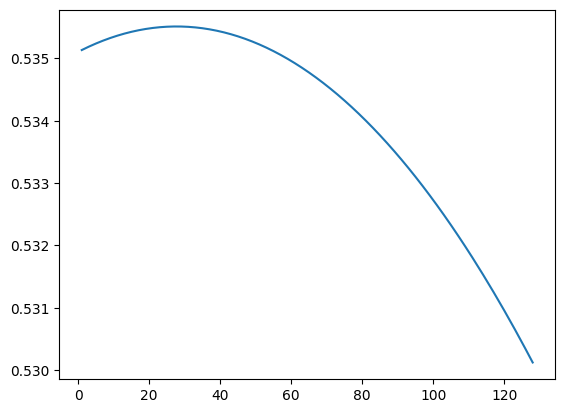

In [33]:
plt.figure()

for i, power in enumerate(ability_powers):
    plt.plot(defense_base_points, eternatus_hp_remained[i])

plt.show()
